In [136]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from sklearn.neighbors import LocalOutlierFactor
import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("bank_transactions_data_2.csv")

df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,11-04-2023 16:29,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,04-11-2024 08:08
1,TX000002,AC00455,376.24,27-06-2023 16:44,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,04-11-2024 08:09
2,TX000003,AC00019,126.29,10-07-2023 18:16,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,04-11-2024 08:07
3,TX000004,AC00070,184.50,05-05-2023 16:32,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,04-11-2024 08:09
4,TX000005,AC00411,13.45,16-10-2023 17:51,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,04-11-2024 08:06


In [137]:
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

In [138]:
df.duplicated().sum()

np.int64(0)

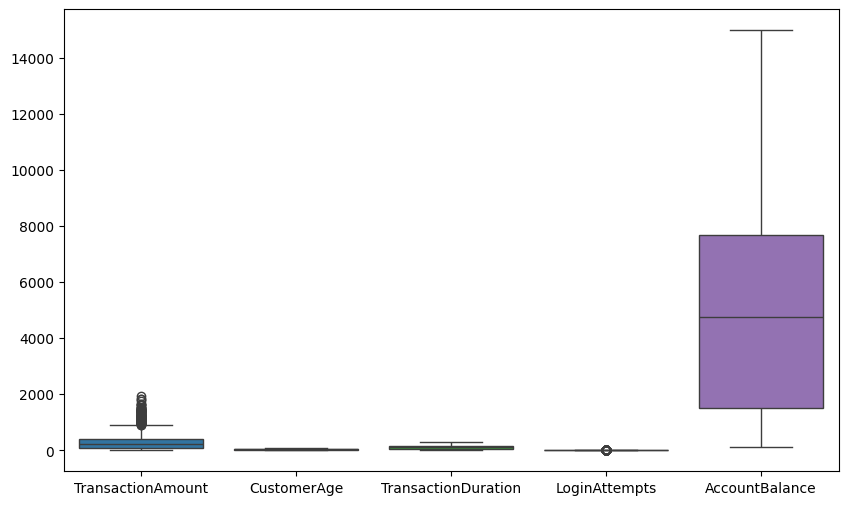

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.show()

In [140]:
from scipy import stats
z_scores = stats.zscore(df['TransactionAmount'])
df['Amount_Z_Score'] = z_scores
print(f"\nOutliers (|z-score| > 3): {len(df[abs(df['Amount_Z_Score']) > 3])}")


Outliers (|z-score| > 3): 48


#converting date and time 

In [141]:
id_cols = ['TransactionID', 'AccountID']
date_cols = ['TransactionDate', 'PreviousTransactionDate']


for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')




In [142]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'Amount_Z_Score']
Categorical columns: ['TransactionID', 'AccountID', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation']


In [143]:
for col in numeric_cols:
    z_scores = stats.zscore(df[col])
    outliers = (np.abs(z_scores) > 3).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")

TransactionAmount: 48 outliers (1.91%)
CustomerAge: 0 outliers (0.00%)
TransactionDuration: 0 outliers (0.00%)
LoginAttempts: 95 outliers (3.78%)
AccountBalance: 0 outliers (0.00%)
Amount_Z_Score: 48 outliers (1.91%)


In [144]:
df["Hour"] = df["TransactionDate"].dt.hour
df["DayOfWeek"] = df["TransactionDate"].dt.dayofweek
df["Weekend"] = df["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)
df["Month"] = df["TransactionDate"].dt.month

In [145]:
if "PreviousTransactionDate" in df.columns:
    df["TimeSinceLastTx"] = (df["TransactionDate"] - df["PreviousTransactionDate"]).dt.total_seconds() / 3600
    df.fillna({"TimeSinceLastTx": df["TimeSinceLastTx"].median()}, inplace=True)

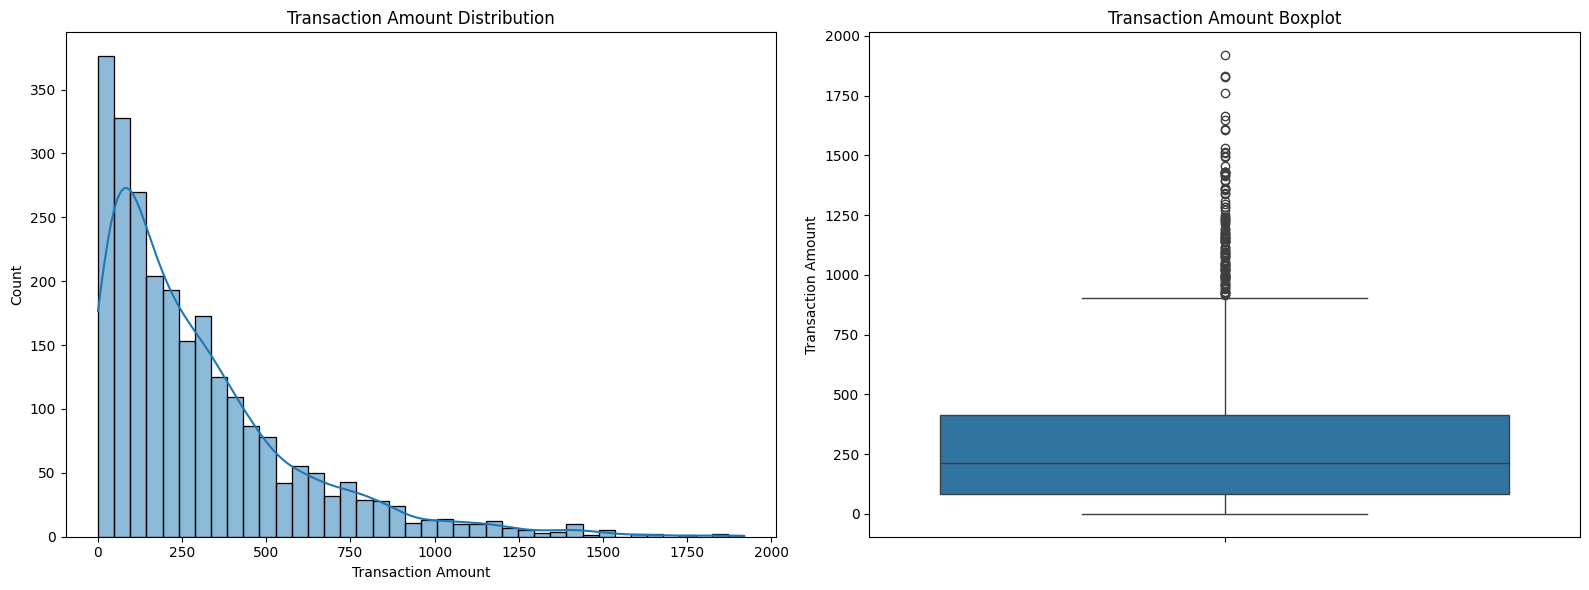

In [146]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['TransactionAmount'], kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['TransactionAmount'])
plt.title('Transaction Amount Boxplot')
plt.ylabel('Transaction Amount')
plt.tight_layout()
plt.show()

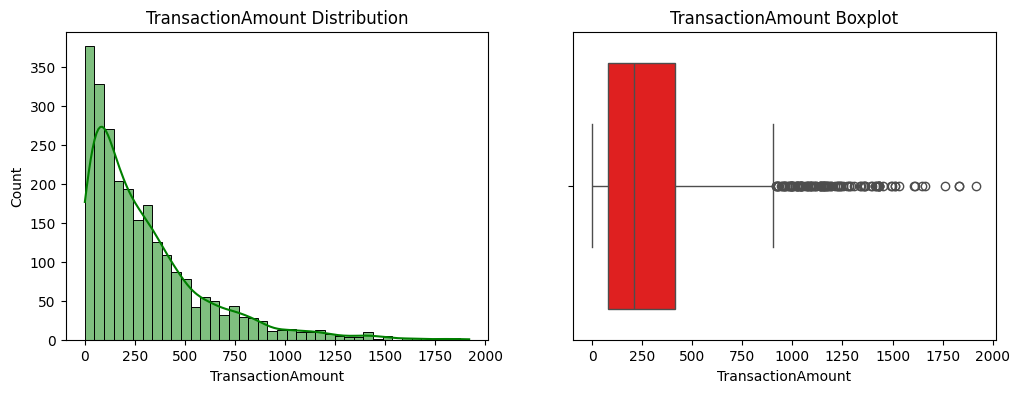

count    2512.000000
mean      297.593778
std       291.946243
min         0.260000
25%        81.885000
50%       211.140000
75%       414.527500
max      1919.110000
Name: TransactionAmount, dtype: float64
Skewness: 1.74, Kurtosis: 3.64



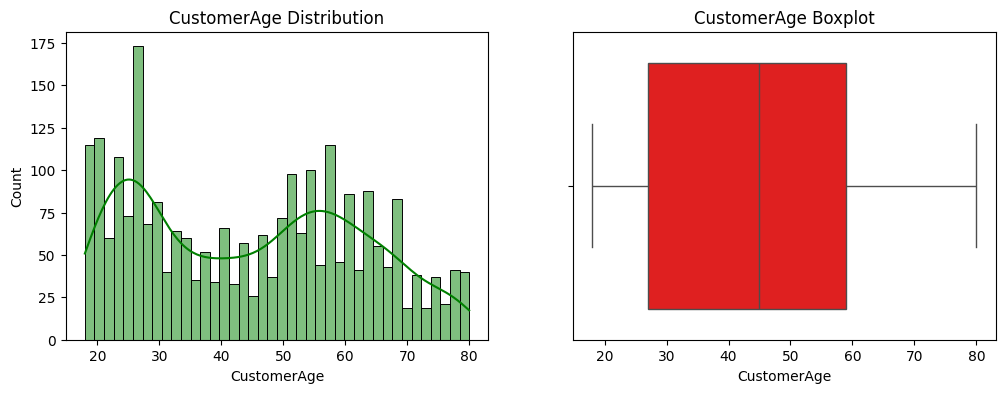

count    2512.000000
mean       44.673965
std        17.792198
min        18.000000
25%        27.000000
50%        45.000000
75%        59.000000
max        80.000000
Name: CustomerAge, dtype: float64
Skewness: 0.15, Kurtosis: -1.22



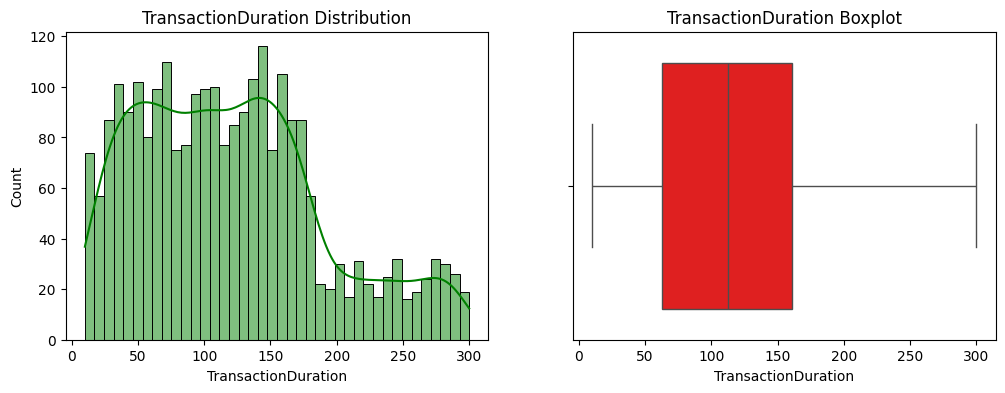

count    2512.000000
mean      119.643312
std        69.963757
min        10.000000
25%        63.000000
50%       112.500000
75%       161.000000
max       300.000000
Name: TransactionDuration, dtype: float64
Skewness: 0.60, Kurtosis: -0.26



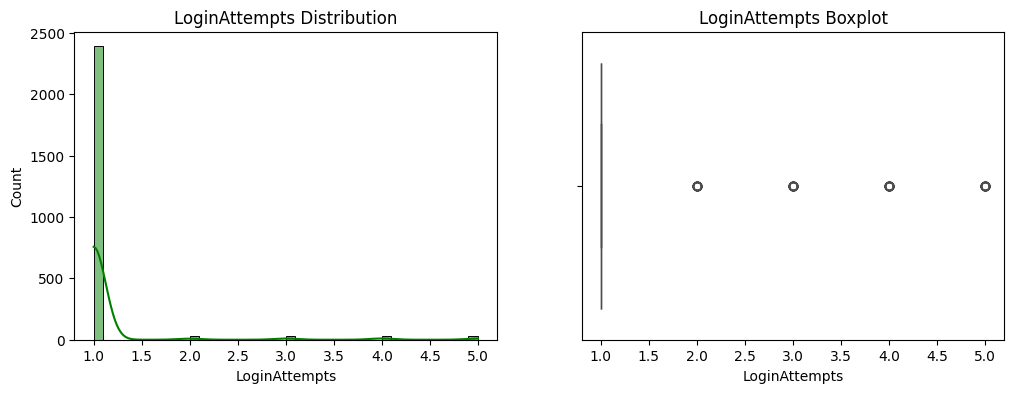

count    2512.000000
mean        1.124602
std         0.602662
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: LoginAttempts, dtype: float64
Skewness: 5.17, Kurtosis: 26.67



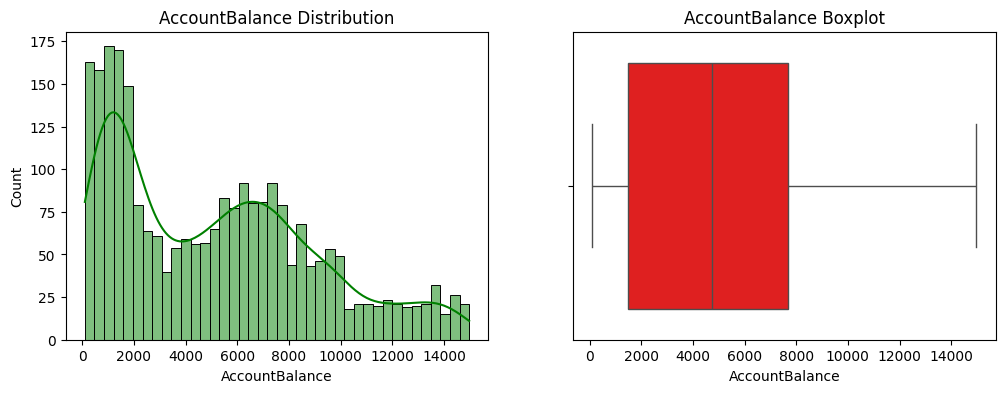

count     2512.000000
mean      5114.302966
std       3900.942499
min        101.250000
25%       1504.370000
50%       4735.510000
75%       7678.820000
max      14977.990000
Name: AccountBalance, dtype: float64
Skewness: 0.60, Kurtosis: -0.56



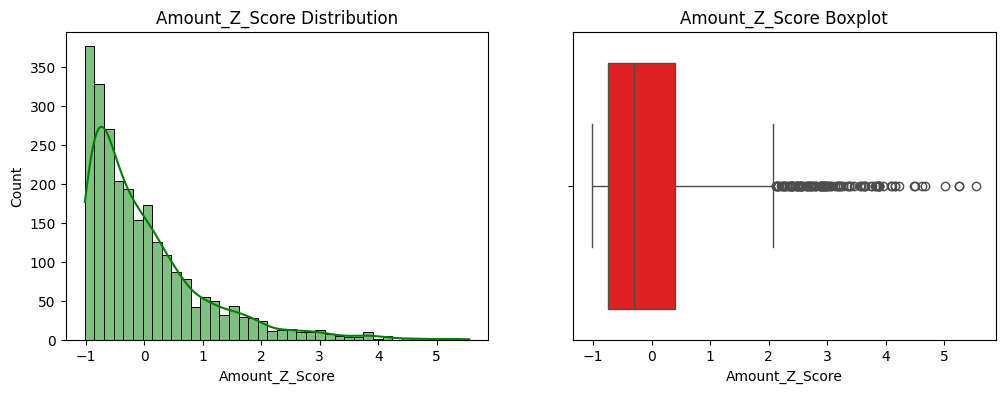

count    2.512000e+03
mean    -1.414297e-16
std      1.000199e+00
min     -1.018657e+00
25%     -7.390118e-01
50%     -2.961881e-01
75%      4.006114e-01
max      5.555266e+00
Name: Amount_Z_Score, dtype: float64
Skewness: 1.74, Kurtosis: 3.64



In [147]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(df[col], kde=True, bins=40, ax=axes[0], color="green")
    axes[0].set_title(f"{col} Distribution")
    sns.boxplot(x=df[col], ax=axes[1], color="red")
    axes[1].set_title(f"{col} Boxplot")
    plt.show()
    print(df[col].describe())
    print(f"Skewness: {df[col].skew():.2f}, Kurtosis: {df[col].kurt():.2f}\n")


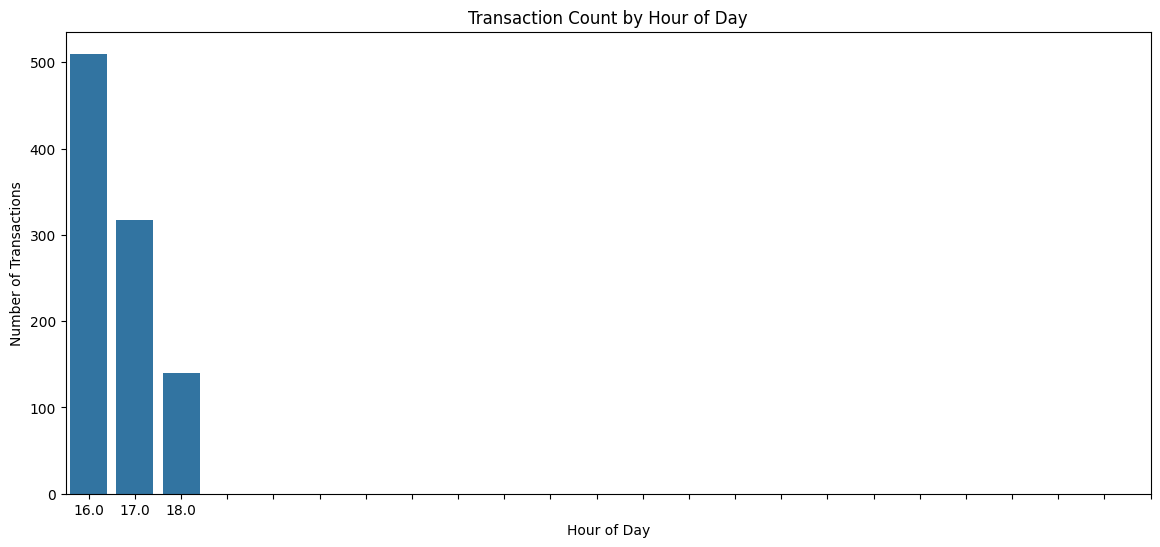

In [148]:
plt.figure(figsize=(14, 6))
hour_counts = df.groupby('Hour').size()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Transaction Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.show()

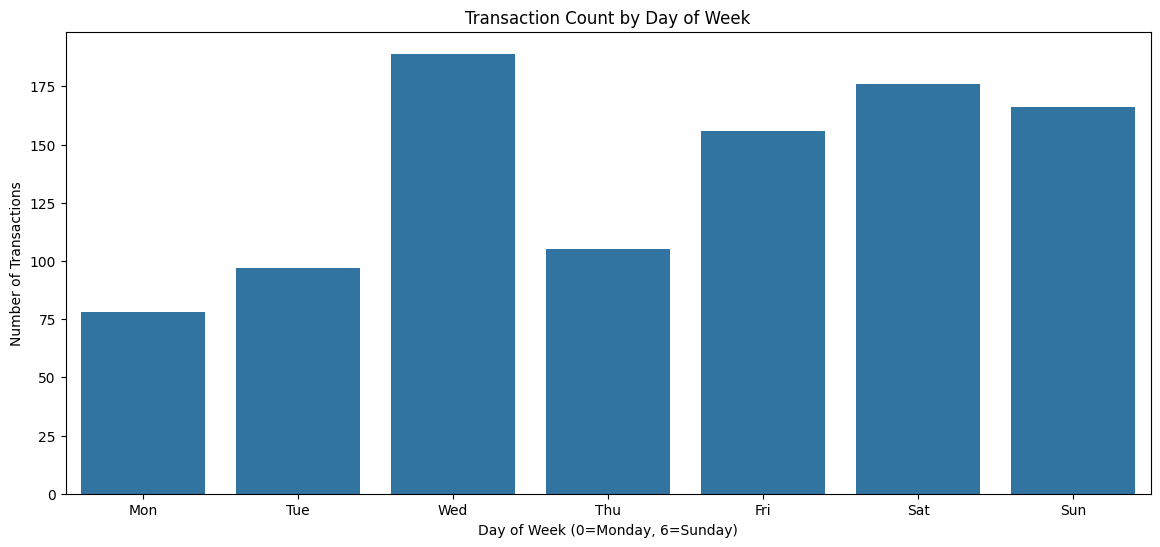

In [149]:
plt.figure(figsize=(14, 6))
day_counts = df.groupby('DayOfWeek').size()
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Transaction Count by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

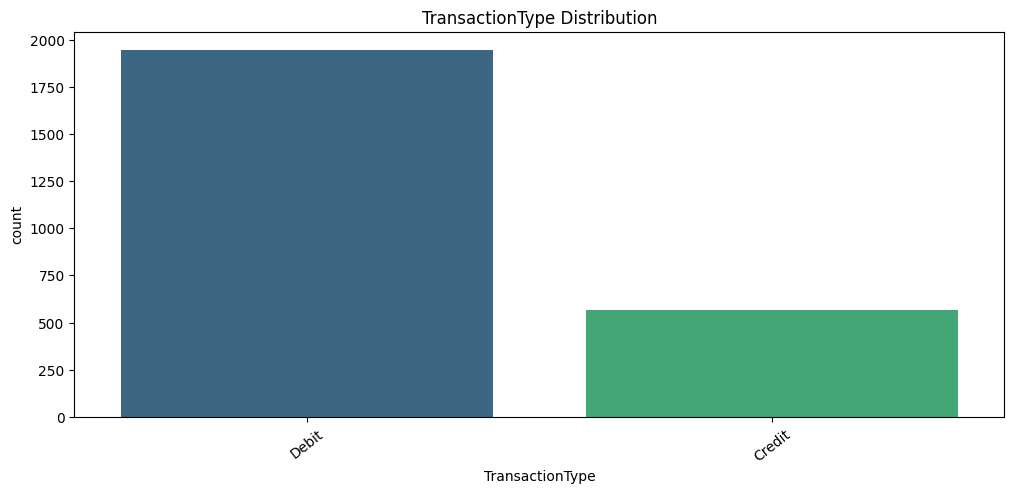

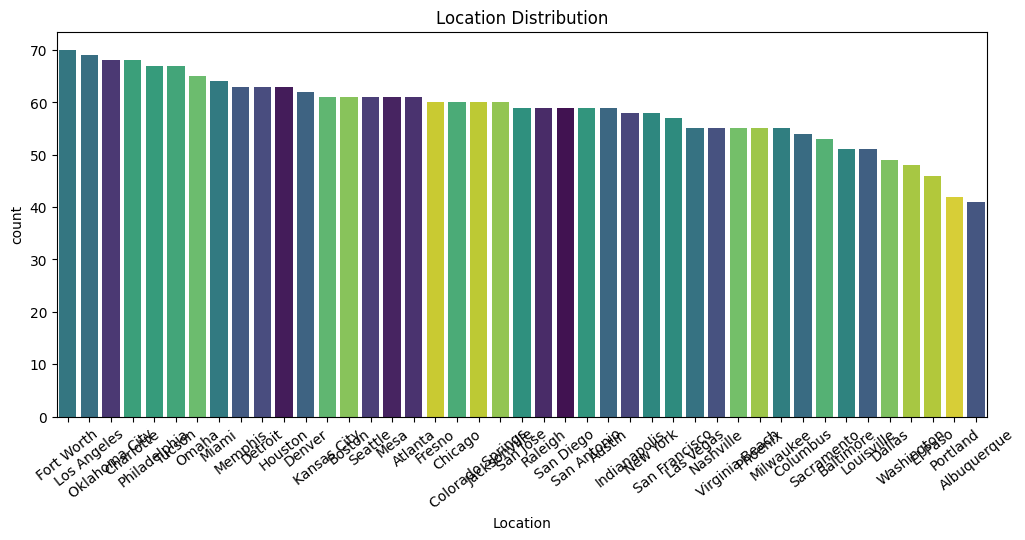

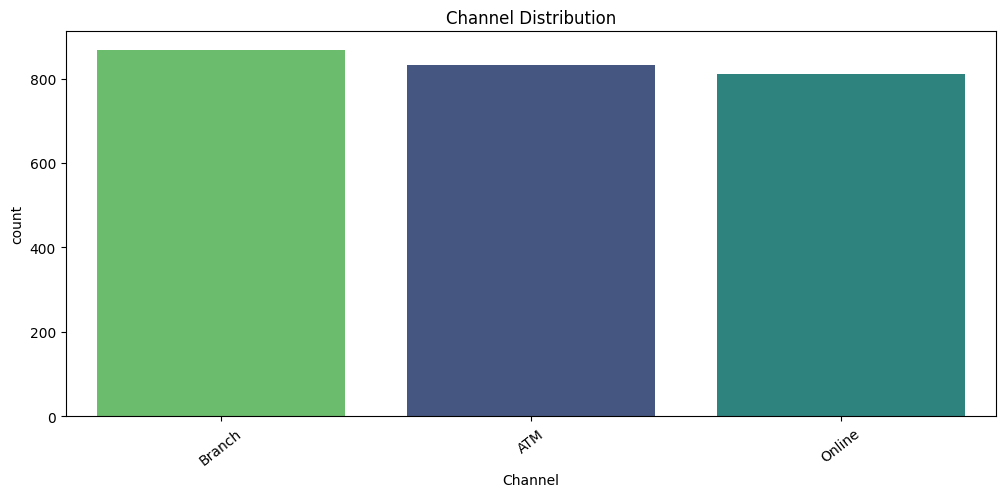

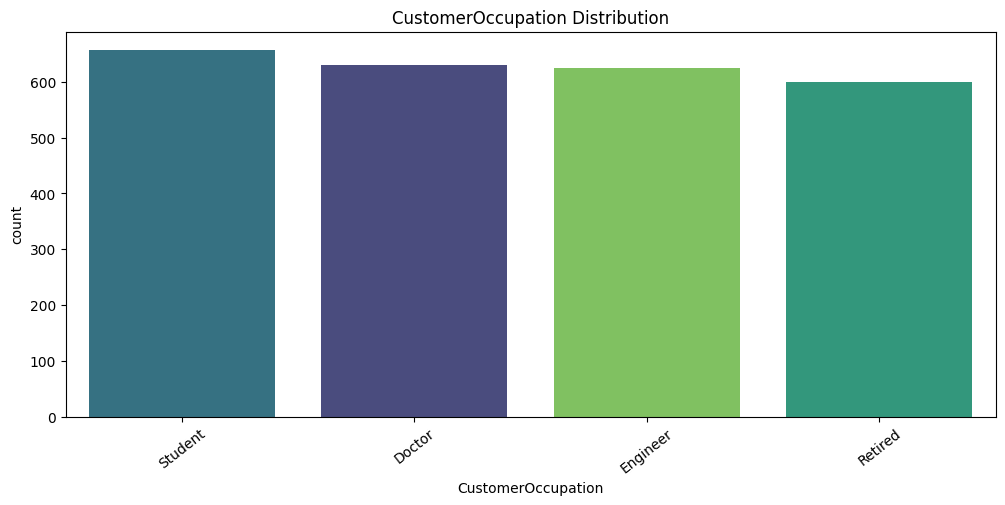

In [150]:
cat_cols = [
    'TransactionType', 
    'Location', 
    'Channel', 
    'CustomerOccupation'
]

for col in cat_cols:
    plt.figure(figsize=(12,5))
    order = df[col].value_counts().index
    sns.countplot(
    x=col,
    hue=col,
    data=df,
    order=order,
    palette="viridis",
    legend=False
)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=38)
    plt.show()

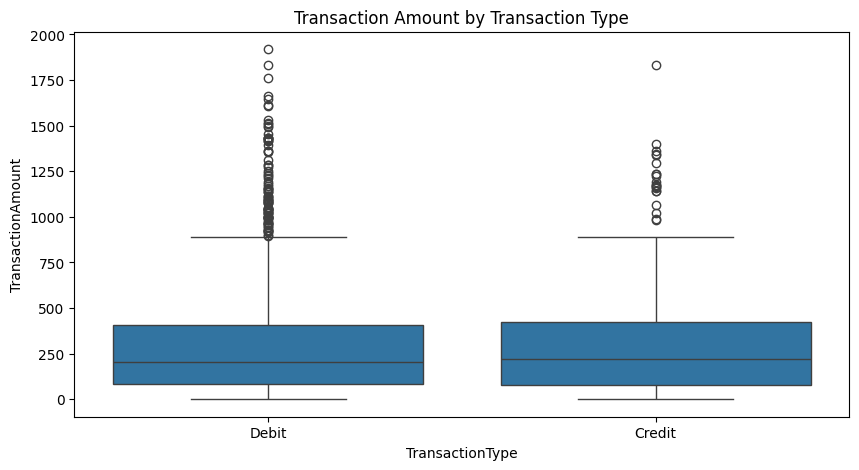

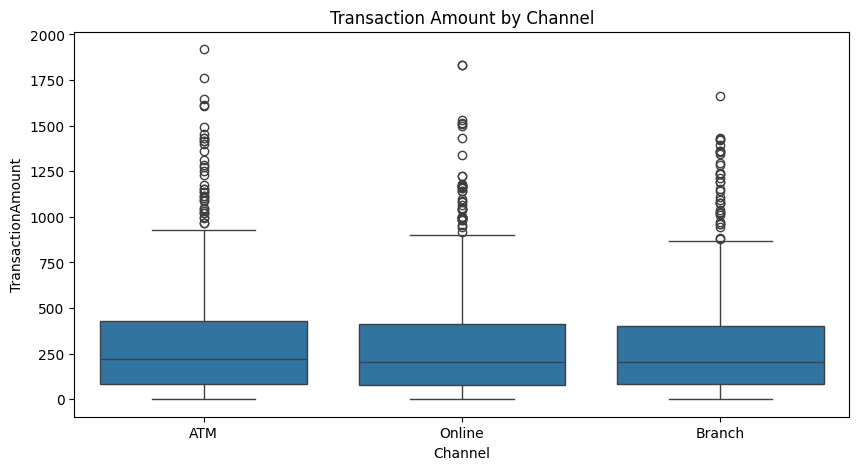

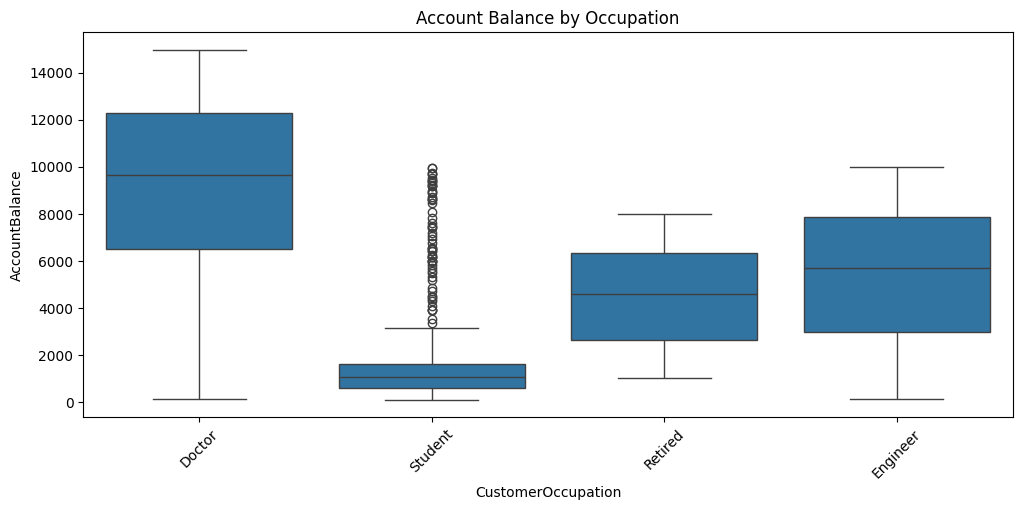

In [151]:
plt.figure(figsize=(10,5))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=df)
plt.title("Transaction Amount by Transaction Type")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Channel', y='TransactionAmount', data=df)
plt.title("Transaction Amount by Channel")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='CustomerOccupation', y='AccountBalance', data=df)
plt.title("Account Balance by Occupation")
plt.xticks(rotation=45)
plt.show()

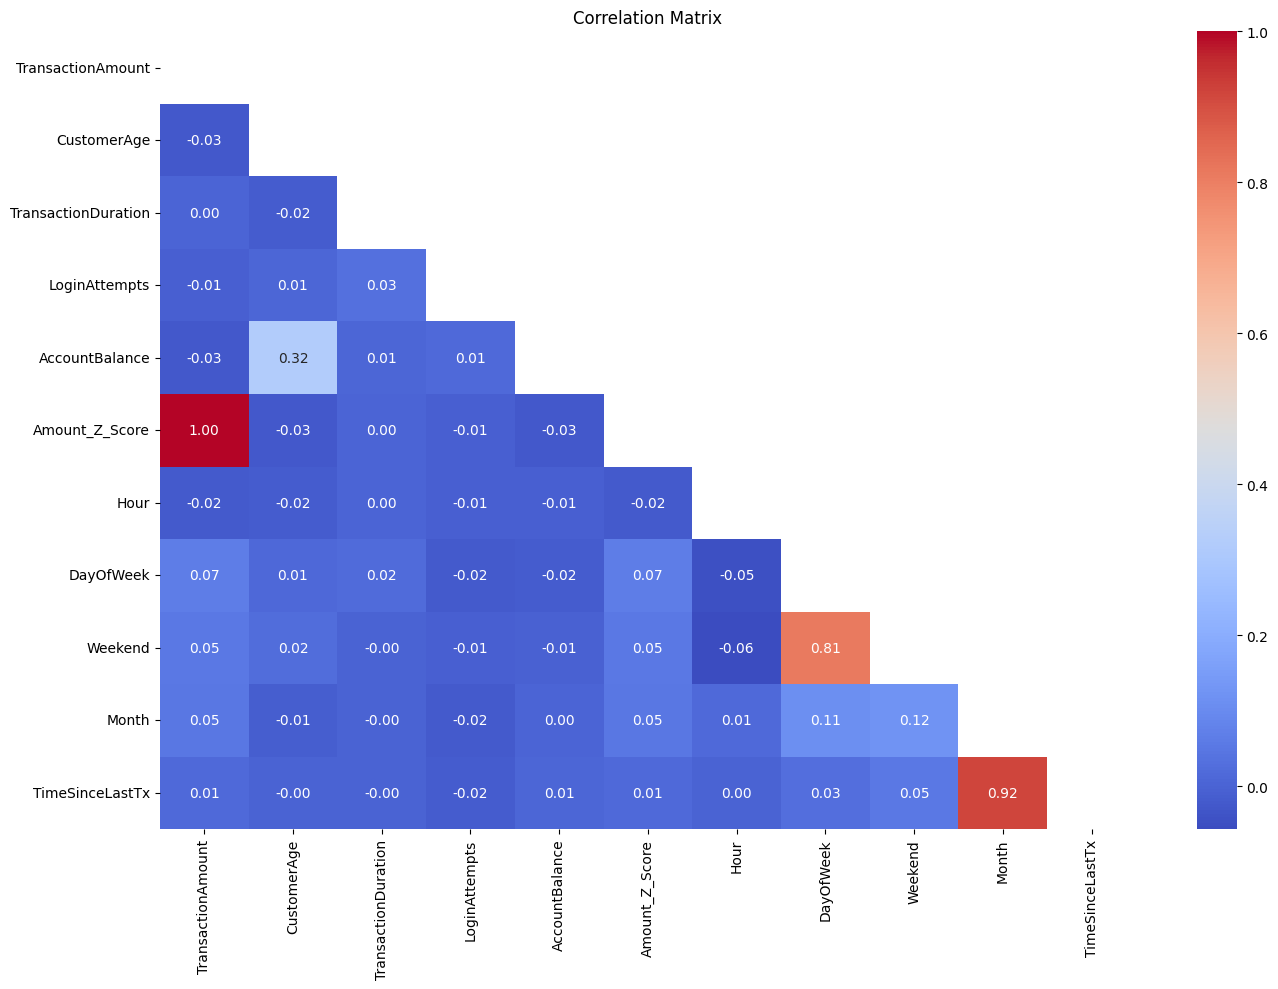

In [152]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(14, 10))
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [153]:
avg_tx_amount_by_type = df.groupby('TransactionType')['TransactionAmount'].transform('mean')
df['Amount_to_AvgByType_Ratio'] = df['TransactionAmount'] / avg_tx_amount_by_type


In [154]:

device_tx_count = df.groupby('DeviceID').size().reset_index(name='DeviceTxCount')
df = pd.merge(df, device_tx_count, on='DeviceID', how='left')



In [155]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])



In [156]:
from sklearn.preprocessing import StandardScaler

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_cols])   # <-- THIS was missing earlier

df_scaled_df = pd.DataFrame(df_scaled, columns=num_cols)

print(f"Final dataset shape: {df.shape}")


Final dataset shape: (2512, 24)


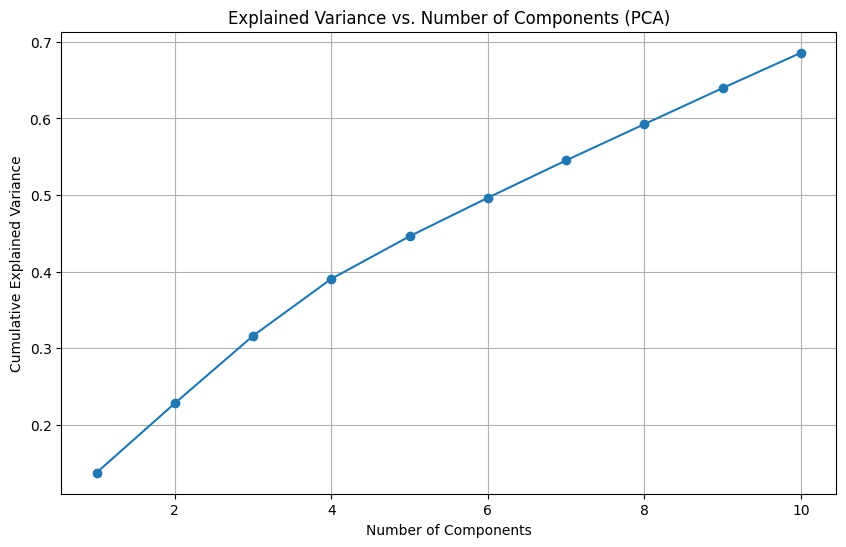

In [157]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_numeric = df.select_dtypes(include=["int64", "float64"])

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42))
])

pca_result = pipeline.fit_transform(df_numeric)


explained_var = pipeline.named_steps["pca"].explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components (PCA)")
plt.grid(True)
plt.show()


In [158]:


explained_var = pipeline.named_steps["pca"].explained_variance_ratio_
print(f"Explained variance ratio:\n{explained_var}")
print(f"Cumulative explained variance: {explained_var.sum():.4f}")


Explained variance ratio:
[0.13751026 0.09064202 0.08811165 0.07441551 0.05555501 0.05029614
 0.04879334 0.04733862 0.04710824 0.04607965]
Cumulative explained variance: 0.6859



Applying t-SNE for visualization...


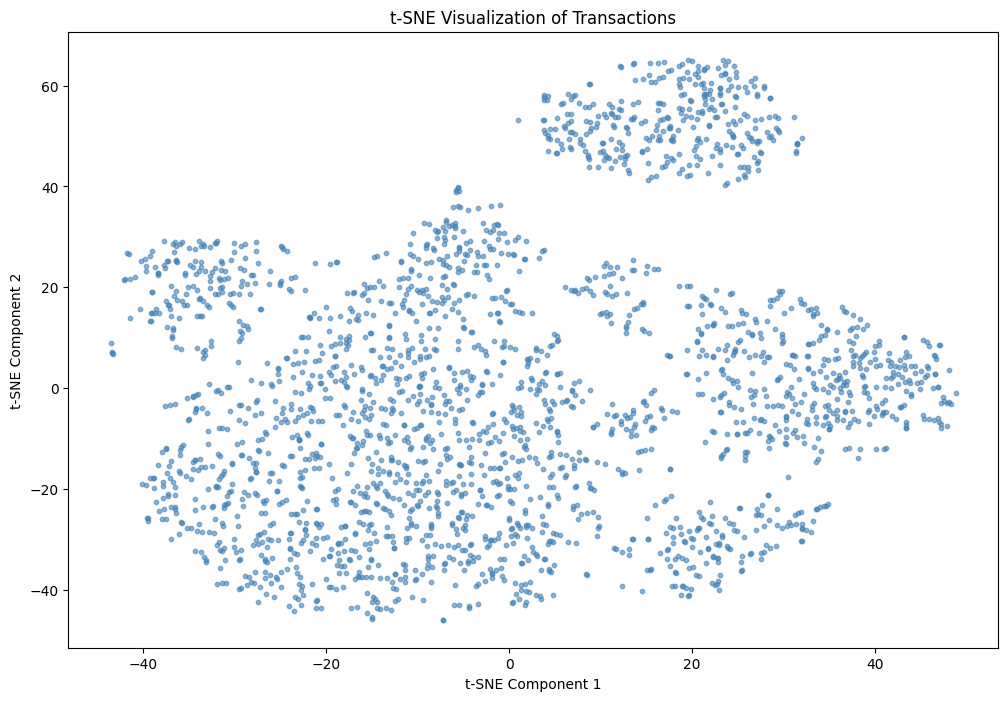

In [159]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("\nApplying t-SNE for visualization...")

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    max_iter=1000
)


tsne_results = tsne.fit_transform(pca_result)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.6, c="steelblue")
plt.title("t-SNE Visualization of Transactions")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [160]:
param_grid = {
    'n_estimators': [100, 200],
    'contamination': [0.01, 0.02, 0.05],
    'max_samples': [100, 'auto']
}

In [161]:
iso_forest = IsolationForest(random_state=42)
grid_search = GridSearchCV(
    estimator=iso_forest,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=0
)
grid_search.fit(df_scaled)


,estimator,IsolationFore...ndom_state=42)
,param_grid,"{'contamination': [0.01, 0.02, ...], 'max_samples': [100, 'auto'], 'n_estimators': [100, 200]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [162]:
print(f"Best Isolation Forest parameters: {grid_search.best_params_}")
best_iso_forest = grid_search.best_estimator_

Best Isolation Forest parameters: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 100}


In [163]:
df['IF_Anomaly'] = best_iso_forest.predict(df_scaled)
df['IF_Score'] = best_iso_forest.decision_function(df_scaled)

In [164]:
df['IF_Anomaly'] = df['IF_Anomaly'].map({1: 0, -1: 1})

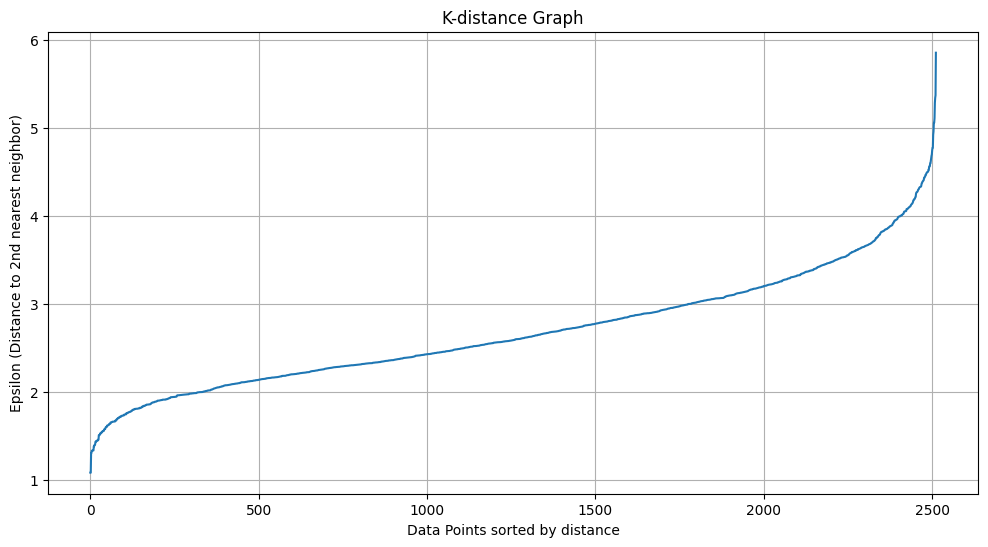

In [165]:
from sklearn.neighbors import NearestNeighbors
imputer = SimpleImputer(strategy="mean")  # or median if preferred
df_scaled_imputed = imputer.fit_transform(df_scaled)
nn = NearestNeighbors(n_neighbors=2)
nn.fit(df_scaled_imputed)
distances, indices = nn.kneighbors(df_scaled_imputed)
distances = np.sort(distances[:, 1])

plt.figure(figsize=(12, 6))
plt.plot(range(len(distances)), distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (Distance to 2nd nearest neighbor)')
plt.grid(True)
plt.show()

In [166]:
from sklearn.cluster import DBSCAN
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_values = [5, 10, 15, 20]

best_silhouette = -1
best_eps = None
best_min_samples = None

print("\nFinding optimal DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_scaled_imputed)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1 and not all(l == -1 for l in labels):
            try:
                score = silhouette_score(df_scaled, labels)
                print(f"eps={eps}, min_samples={min_samples}, n_clusters={n_clusters}, silhouette={score:.4f}")
                if score > best_silhouette:
                    best_silhouette = score
                    best_eps = eps
                    best_min_samples = min_samples
            except:
                continue

print(f"\nBest DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}, silhouette={best_silhouette:.4f}")


Finding optimal DBSCAN parameters...

Best DBSCAN parameters: eps=None, min_samples=None, silhouette=-1.0000


In [167]:
dbscan = DBSCAN(eps=best_eps if best_eps else 2.5, min_samples=best_min_samples if best_min_samples else 10)
df['DBSCAN_Label'] = dbscan.fit_predict(df_scaled_imputed)
df['DBSCAN_Anomaly'] = df['DBSCAN_Label'].apply(lambda x: 1 if x == -1 else 0)

In [168]:
#pip install pyod


In [169]:
from pyod.models.hbos import HBOS
hbos = HBOS(
    contamination=0.02,   # expected fraud percentage
    n_bins=10             # number of histogram bins
)

# Fit model
hbos.fit(df_scaled_imputed)

# Predict anomalies
# 1 = anomaly, 0 = normal
hbos_labels = hbos.predict(df_scaled_imputed)

# Anomaly scores (higher = more anomalous)
hbos_scores = hbos.decision_scores_

# Count anomalies
anomaly_count = np.sum(hbos_labels == 1)
anomaly_percent = anomaly_count / len(hbos_labels) * 100




In [170]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma='auto')
df['OCSVM_Anomaly'] = ocsvm.fit_predict(df_scaled_imputed)
df['OCSVM_Score'] = ocsvm.decision_function(df_scaled_imputed)

In [171]:
df['OCSVM_Anomaly'] = df['OCSVM_Anomaly'].map({1: 0, -1: 1})

In [172]:
print("\nAnomaly counts by each method:")
print(f"Isolation Forest Anomalies: {df['IF_Anomaly'].sum()} ({df['IF_Anomaly'].mean()*100:.2f}%)")
print(f"DBSCAN Anomalies: {df['DBSCAN_Anomaly'].sum()} ({df['DBSCAN_Anomaly'].mean()*100:.2f}%)")
print(f"One-Class SVM Anomalies: {df['OCSVM_Anomaly'].sum()} ({df['OCSVM_Anomaly'].mean()*100:.2f}%)")
print(f"HBOS Anomalies: {anomaly_count} ({anomaly_percent:.2f}%)")



Anomaly counts by each method:
Isolation Forest Anomalies: 26 (1.04%)
DBSCAN Anomalies: 2135 (84.99%)
One-Class SVM Anomalies: 127 (5.06%)
HBOS Anomalies: 51 (2.03%)


In [173]:
df['Ensemble_Anomaly'] = ((df['IF_Anomaly'] + df['DBSCAN_Anomaly'] + df['OCSVM_Anomaly']) >= 2).astype(int)
print(f"Ensemble Anomalies (majority vote): {df['Ensemble_Anomaly'].sum()} ({df['Ensemble_Anomaly'].mean()*100:.2f}%)")

Ensemble Anomalies (majority vote): 129 (5.14%)


In [174]:
df['HBOS_Anomaly'] = hbos_labels


In [175]:
df['Ensemble_Anomaly'] = (
    (df['IF_Anomaly'] +
     df['OCSVM_Anomaly'] +
     df['HBOS_Anomaly']) >= 2
).astype(int)

print(
    f"Ensemble Anomalies (majority vote): "
    f"{df['Ensemble_Anomaly'].sum()} "
    f"({df['Ensemble_Anomaly'].mean()*100:.2f}%)"
)


Ensemble Anomalies (majority vote): 32 (1.27%)


In [176]:
high_conf_fraud = df[df['Ensemble_Anomaly'] == 1]
high_conf_fraud.head()


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,...,Amount_to_AvgByType_Ratio,DeviceTxCount,IF_Anomaly,IF_Score,DBSCAN_Label,DBSCAN_Anomaly,OCSVM_Anomaly,OCSVM_Score,Ensemble_Anomaly,HBOS_Anomaly
85,85,96,1340.19,NaT,0,2,557,193,11,2,...,4.372547,7,1,-0.010885,-1,1,1,-0.666338,1,0
113,113,119,213.76,2023-01-03 17:52:00,0,9,557,457,8,0,...,0.697420,7,1,-0.007070,-1,1,1,-1.121626,1,0
176,176,358,1362.55,2023-10-02 18:07:00,1,12,207,580,0,0,...,4.618950,3,0,0.014215,-1,1,1,-1.456662,1,1
190,190,391,1422.55,2023-10-07 17:49:00,1,42,552,251,71,1,...,4.822346,3,1,-0.015314,-1,1,1,-0.621379,1,1
248,248,249,842.01,2023-12-09 16:43:00,0,41,204,490,14,2,...,2.747169,2,1,-0.007679,-1,1,1,-0.435590,1,1


In [177]:
df.groupby('Ensemble_Anomaly')['TransactionAmount'].describe()


,count,mean,std,min,25%,50%,75%,max
Ensemble_Anomaly,,,,,,,,
0,2480.0,288.339500,278.134543,0.26,80.8275,206.895,404.1225,1919.11
1,32.0,1014.800313,424.029751,117.25,794.7000,995.165,1345.7800,1830.00


In [178]:
fraud = df[df['Ensemble_Anomaly'] == 1]
normal = df[df['Ensemble_Anomaly'] == 0]

fraud[['TransactionAmount', 'LoginAttempts', 'TimeSinceLastTx']].describe()


,TransactionAmount,LoginAttempts,TimeSinceLastTx
count,32.000000,32.000000,32.000000
mean,1014.800313,1.375000,-6835.585417
std,424.029751,1.039541,2783.565903
min,117.250000,1.000000,-11127.666667
25%,794.700000,1.000000,-8997.125000
50%,995.165000,1.000000,-6782.750000
75%,1345.780000,1.000000,-4262.720833
max,1830.000000,5.000000,-2942.483333


In [179]:
normal[['TransactionAmount', 'LoginAttempts', 'TimeSinceLastTx']].describe()


,TransactionAmount,LoginAttempts,TimeSinceLastTx
count,2480.000000,2480.000000,2480.000000
mean,288.339500,1.121371,-6847.688790
std,278.134543,0.594606,1516.383333
min,0.260000,1.000000,-11150.966667
25%,80.827500,1.000000,-6782.750000
50%,206.895000,1.000000,-6782.750000
75%,404.122500,1.000000,-6782.750000
max,1919.110000,5.000000,-2413.750000


In [180]:
#pip install shap

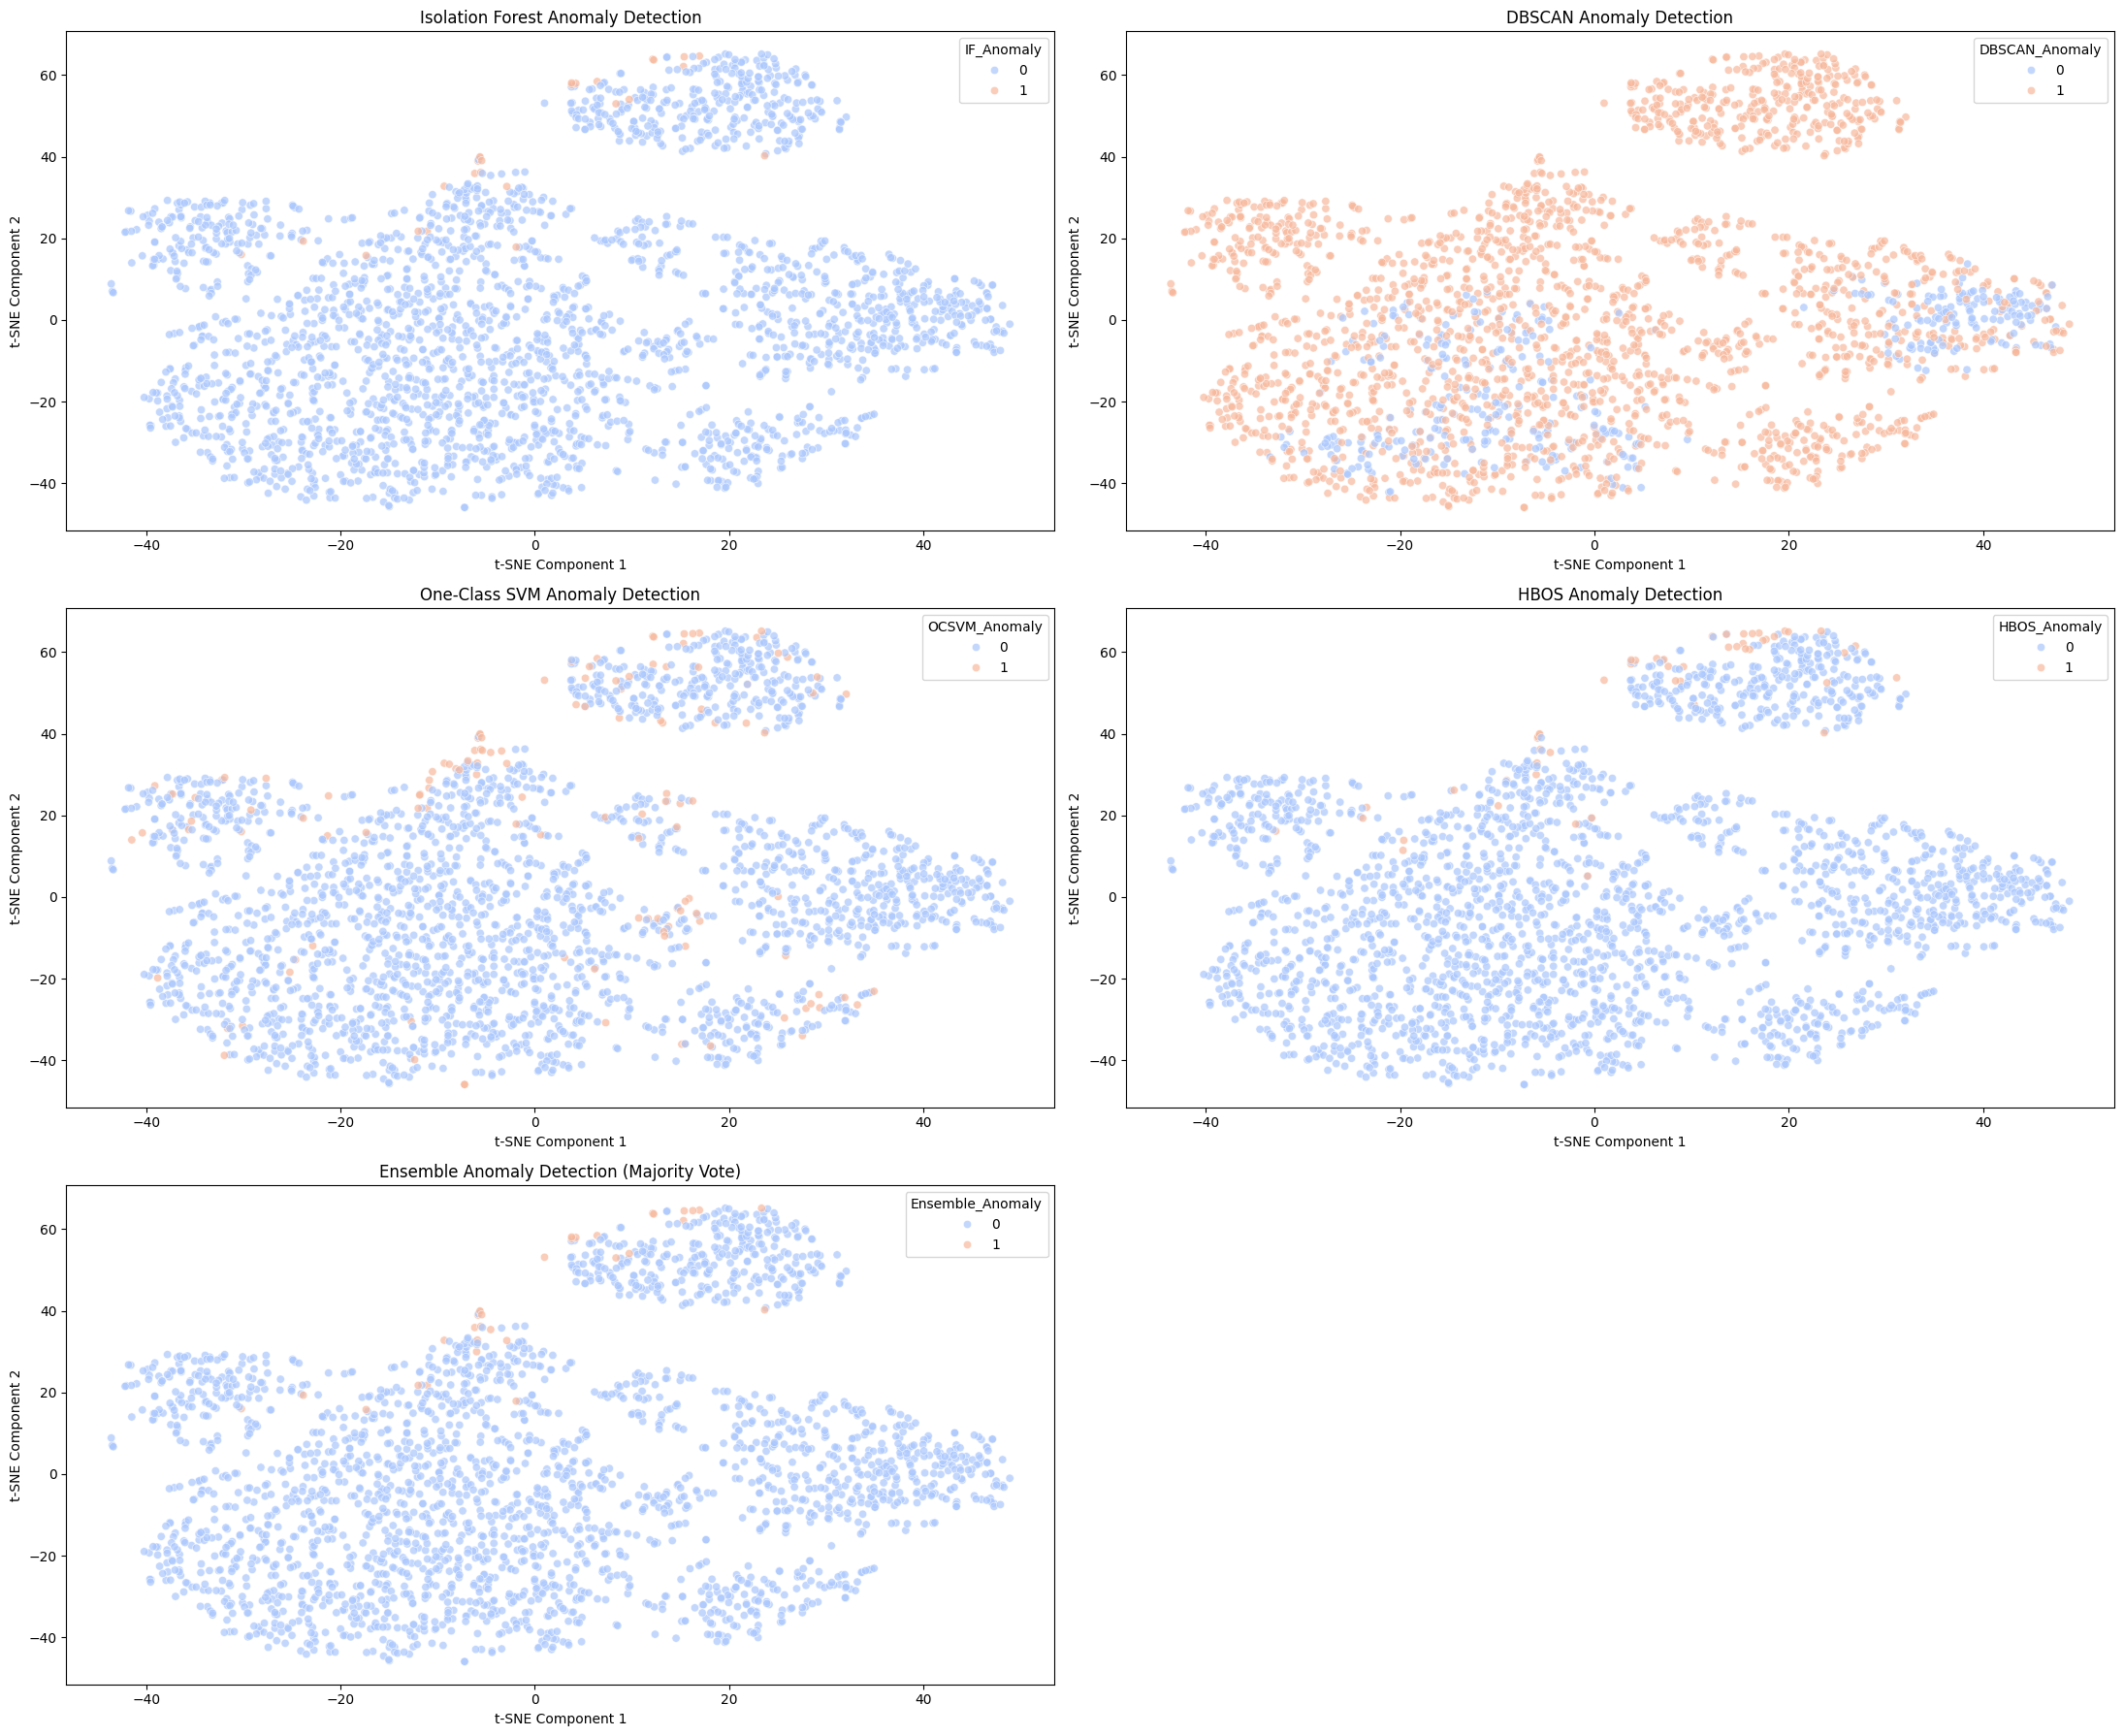

In [181]:
plt.figure(figsize=(22, 18))

plots = [
    ('IF_Anomaly', 'Isolation Forest Anomaly Detection'),
    ('DBSCAN_Anomaly', 'DBSCAN Anomaly Detection'),
    ('OCSVM_Anomaly', 'One-Class SVM Anomaly Detection'),
    ('HBOS_Anomaly', 'HBOS Anomaly Detection'),
    ('Ensemble_Anomaly', 'Ensemble Anomaly Detection (Majority Vote)')
]

for i, (col, title) in enumerate(plots, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=df[col],
        palette='coolwarm',
        alpha=0.7,
        legend='full'
    )
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

# Remove empty subplot (bottom-right)
plt.subplot(3, 2, 6)
plt.axis('off')

plt.tight_layout()
plt.show()


In [182]:
anomaly_row = df[df['Ensemble_Anomaly'] == 1]
print(anomaly_row.T)  


                                          85                   113   \
TransactionID                               85                  113   
AccountID                                   96                  119   
TransactionAmount                      1340.19               213.76   
TransactionDate                            NaT  2023-01-03 17:52:00   
TransactionType                              0                    0   
Location                                     2                    9   
DeviceID                                   557                  557   
IP Address                                 193                  457   
MerchantID                                  11                    8   
Channel                                      2                    0   
CustomerAge                                 54                   78   
CustomerOccupation                           1                    2   
TransactionDuration                         30                  282   
LoginA

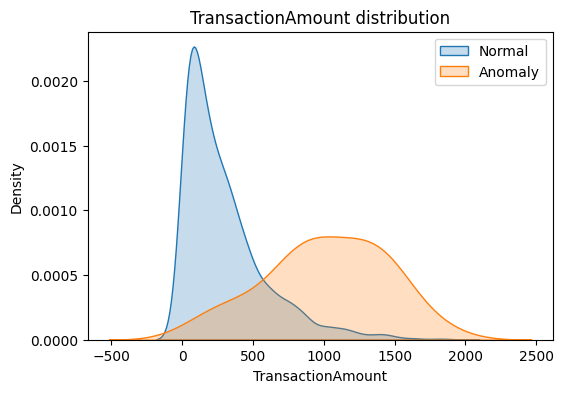

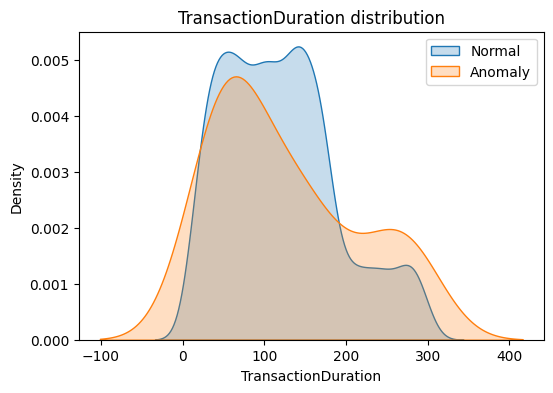

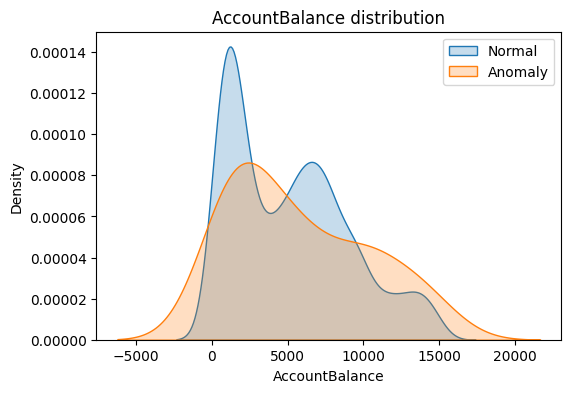

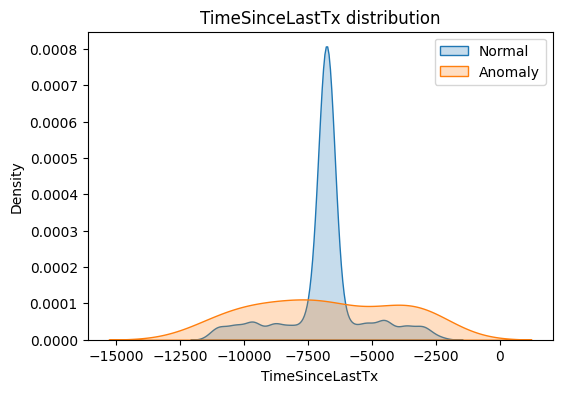

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_check = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'TimeSinceLastTx']

for feat in features_to_check:
    plt.figure(figsize=(6,4))
    sns.kdeplot(df[feat], label='Normal', fill=True)
    sns.kdeplot(df.loc[df['Ensemble_Anomaly'] == 1, feat], label='Anomaly', fill=True)
    plt.title(f'{feat} distribution')
    plt.legend()
    plt.show()


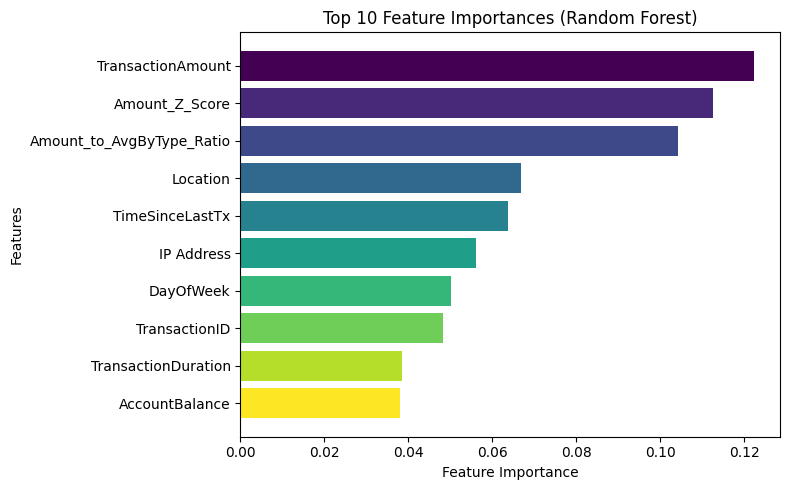

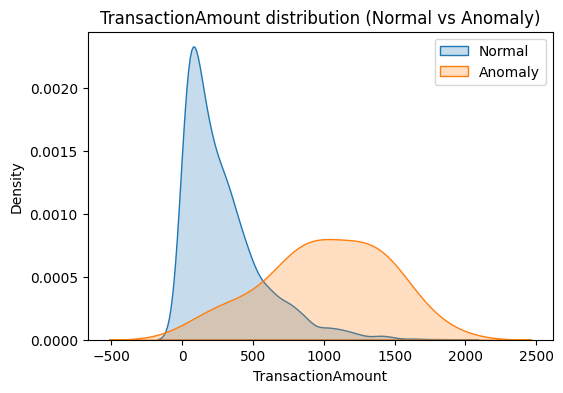

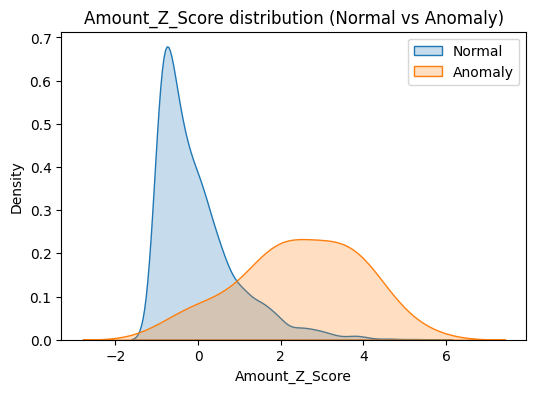

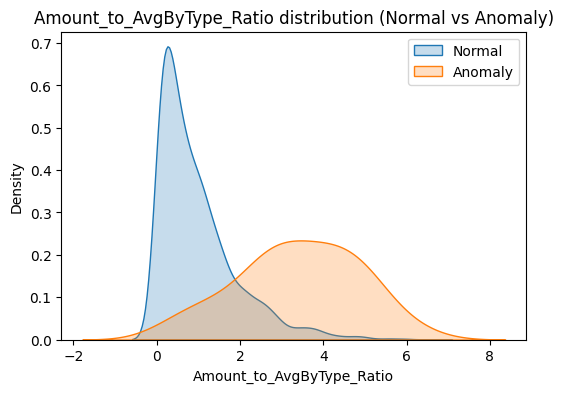

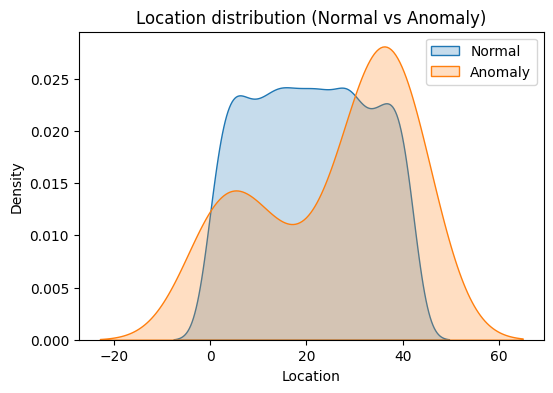

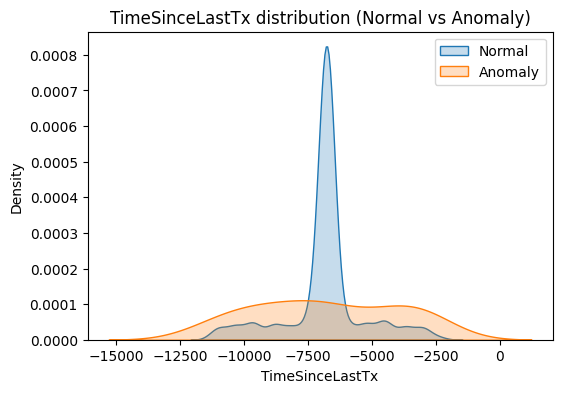

In [184]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Features to use (exclude target columns)
features = df.drop(columns=[
    'IF_Anomaly','IF_Score','DBSCAN_Label','DBSCAN_Anomaly',
    'OCSVM_Anomaly','OCSVM_Score','Ensemble_Anomaly','HBOS_Anomaly',
    'TransactionDate','PreviousTransactionDate'  # dates not used as numeric
])

X = features
y = df['Ensemble_Anomaly']  # target

# Train Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Top 10 features
top_features = importance_df.head(10)

# Gradient colors
colors = plt.cm.viridis(
    np.linspace(0, 1, len(top_features))
)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(
    top_features['Feature'],
    top_features['Importance'],
    color=colors
)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

# Plot top 5 features
top_feats = importance_df['Feature'].head(5).tolist()

for feat in top_feats:
    plt.figure(figsize=(6,4))
    sns.kdeplot(df[df['Ensemble_Anomaly']==0][feat], label='Normal', fill=True)
    sns.kdeplot(df[df['Ensemble_Anomaly']==1][feat], label='Anomaly', fill=True)
    plt.title(f'{feat} distribution (Normal vs Anomaly)')
    plt.legend()
    plt.show()


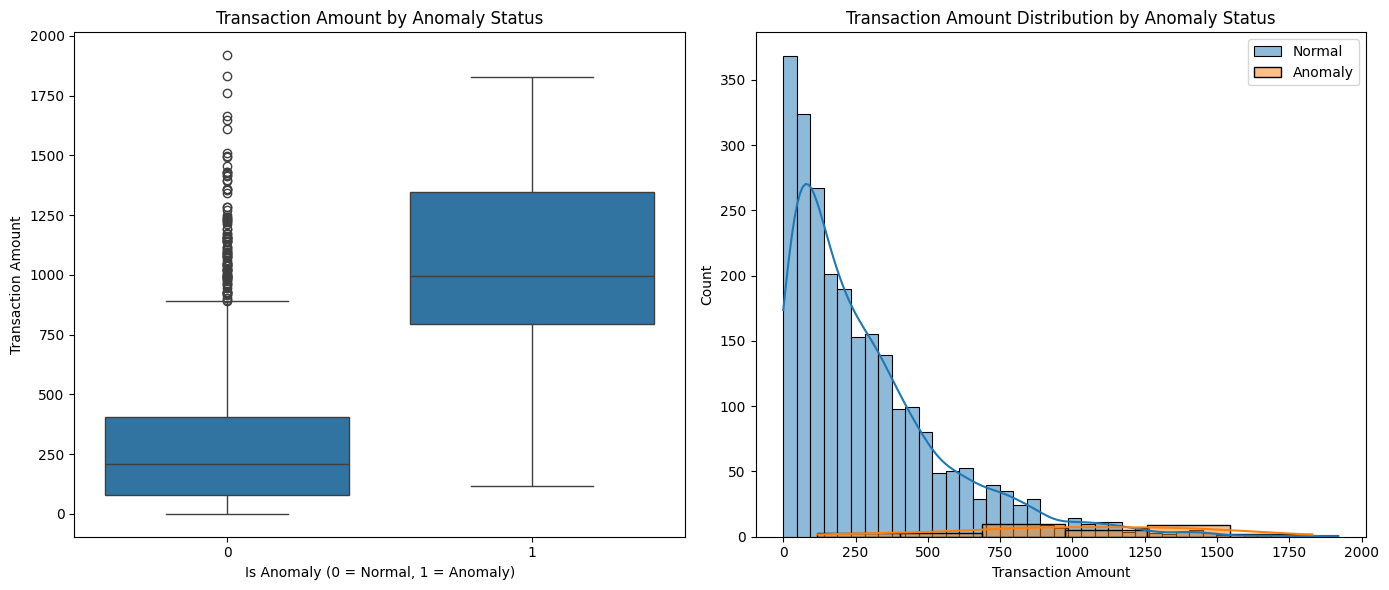

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split after ensemble creation
normal = df[df['Ensemble_Anomaly'] == 0]
anomalies = df[df['Ensemble_Anomaly'] == 1]

plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(
    x='Ensemble_Anomaly',
    y='TransactionAmount',
    data=df
)
plt.title('Transaction Amount by Anomaly Status')
plt.xlabel('Is Anomaly (0 = Normal, 1 = Anomaly)')
plt.ylabel('Transaction Amount')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(
    normal['TransactionAmount'],
    label='Normal',
    kde=True,
    alpha=0.5
)
sns.histplot(
    anomalies['TransactionAmount'],
    label='Anomaly',
    kde=True,
    alpha=0.5
)

plt.title('Transaction Amount Distribution by Anomaly Status')
plt.xlabel('Transaction Amount')
plt.legend()

plt.tight_layout()
plt.show()


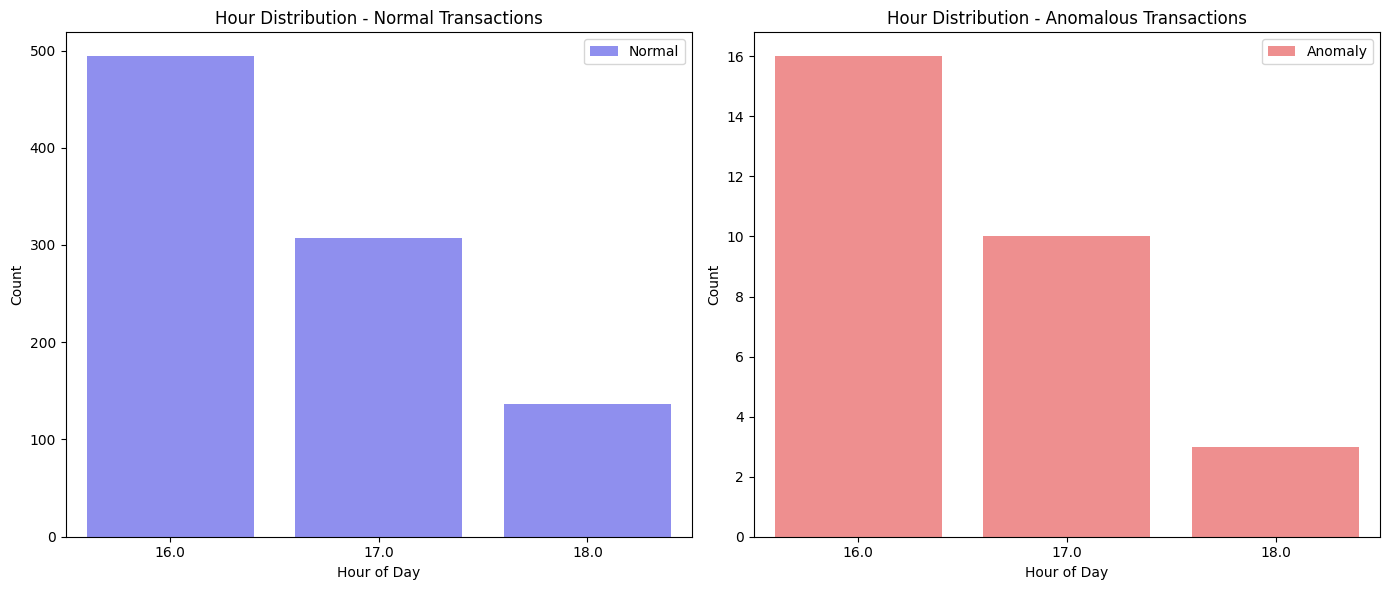

In [186]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Hour', data=normal, color='blue', alpha=0.5, label='Normal')
plt.title('Hour Distribution - Normal Transactions')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='Hour', data=anomalies, color='red', alpha=0.5, label='Anomaly')
plt.title('Hour Distribution - Anomalous Transactions')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

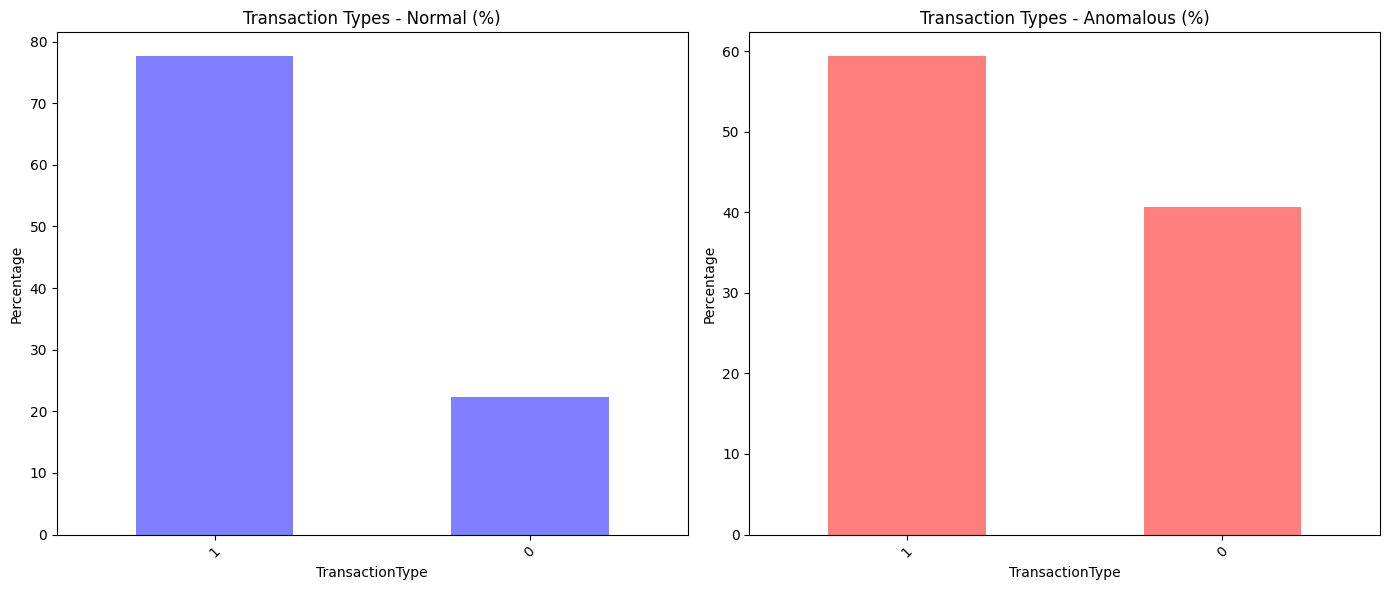

In [187]:
plt.figure(figsize=(14, 6))
normal_tx_type = normal['TransactionType'].value_counts(normalize=True) * 100
anomaly_tx_type = anomalies['TransactionType'].value_counts(normalize=True) * 100

plt.subplot(1, 2, 1)
normal_tx_type.plot(kind='bar', color='blue', alpha=0.5)
plt.title('Transaction Types - Normal (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
anomaly_tx_type.plot(kind='bar', color='red', alpha=0.5)
plt.title('Transaction Types - Anomalous (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

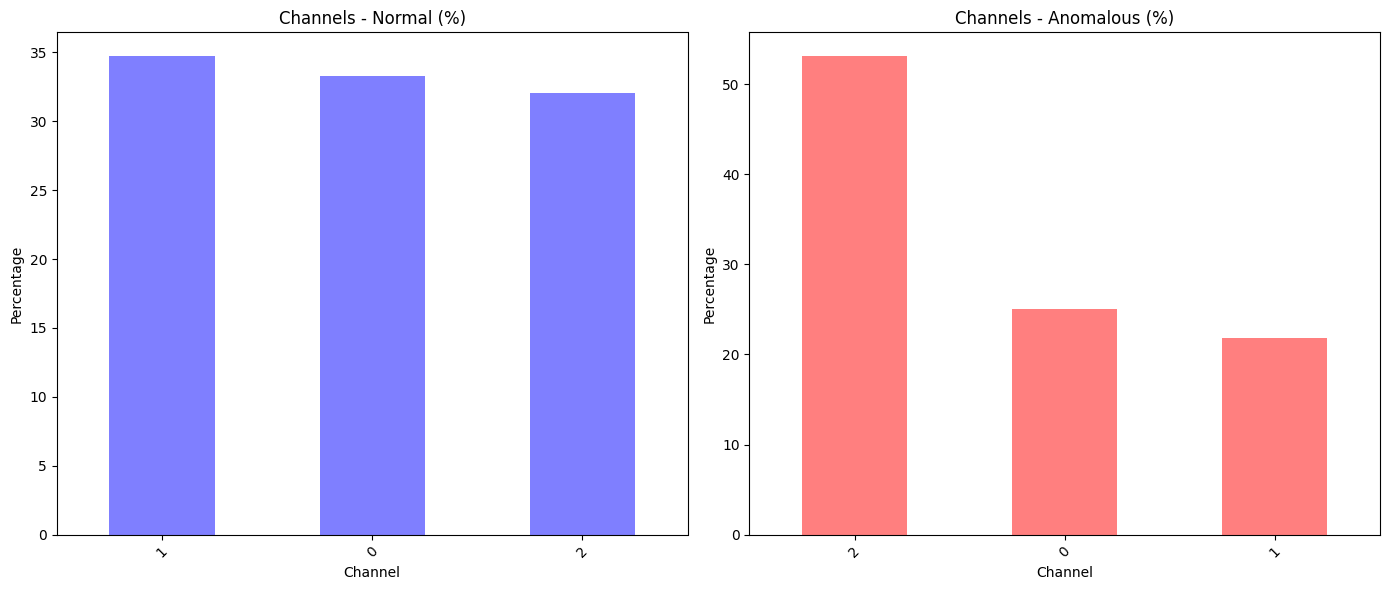

In [188]:
plt.figure(figsize=(14, 6))
normal_channel = normal['Channel'].value_counts(normalize=True) * 100
anomaly_channel = anomalies['Channel'].value_counts(normalize=True) * 100

plt.subplot(1, 2, 1)
normal_channel.plot(kind='bar', color='blue', alpha=0.5)
plt.title('Channels - Normal (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
anomaly_channel.plot(kind='bar', color='red', alpha=0.5)
plt.title('Channels - Anomalous (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [189]:
best_if = grid_search.best_estimator_

df['IF_Anomaly'] = (best_if.predict(df_scaled) == -1).astype(int)
df['IF_Score'] = best_if.decision_function(df_scaled)


In [190]:

df['OCSVM_Score'] = ocsvm.decision_function(df_scaled_imputed)


df['OCSVM_Score_Norm'] = MinMaxScaler().fit_transform(
    (-df[['OCSVM_Score']])
)


In [191]:

df['HBOS_Score'] = hbos.decision_scores_

df['HBOS_Score_Norm'] = MinMaxScaler().fit_transform(
    df[['HBOS_Score']]
)


In [192]:
from sklearn.preprocessing import MinMaxScaler

df['IF_Score_Norm'] = MinMaxScaler().fit_transform(
    (-df[['IF_Score']])
)


In [193]:
df['Ensemble_Score'] = (
    df['IF_Score_Norm'] +
    df['OCSVM_Score_Norm'] +
    df['HBOS_Score_Norm']
) / 3


In [194]:
df[
    ['IF_Score_Norm', 'OCSVM_Score_Norm', 'HBOS_Score_Norm', 'Ensemble_Score']
].describe()


,IF_Score_Norm,OCSVM_Score_Norm,HBOS_Score_Norm,Ensemble_Score
count,2512.000000,2512.000000,2512.000000,2512.000000
mean,0.353104,0.473558,0.349313,0.391992
std,0.175450,0.150941,0.233994,0.166018
min,0.000000,0.000000,0.000000,0.041565
25%,0.213024,0.370377,0.147482,0.254137
50%,0.337698,0.472969,0.287694,0.369330
75%,0.475450,0.582982,0.545993,0.520393
max,1.000000,1.000000,1.000000,0.925768


In [195]:
threshold = df['Ensemble_Score'].quantile(0.95)

df['Final_Anomaly'] = (df['Ensemble_Score'] >= threshold).astype(int)

print(df['Final_Anomaly'].mean() * 100)


5.015923566878981


In [196]:
pd.crosstab(
    df['Ensemble_Anomaly'],
    df['Final_Anomaly'],
    rownames=['Majority Vote'],
    colnames=['Score-Based']
)


Score-Based,0,1
Majority Vote,,
0,2385,95
1,1,31


In [197]:
df.sort_values(
    'Ensemble_Score',
    ascending=False
).head(10)[
    [
        'TransactionID',
        'TransactionAmount',
        'AccountBalance',
        'LoginAttempts',
        'Ensemble_Score'
    ]
]


,TransactionID,TransactionAmount,AccountBalance,LoginAttempts,Ensemble_Score
1703,1703,1294.81,9927.75,1,0.925768
1902,1902,1168.26,1385.74,1,0.920122
340,340,1830.00,2235.70,1,0.903384
1839,1839,813.78,14935.50,1,0.887151
1305,1305,859.30,1146.78,1,0.865751
535,535,1182.86,7696.16,1,0.862385
190,190,1422.55,5674.32,1,0.861975
2445,2445,403.01,10513.52,3,0.857199
475,475,1431.30,1058.13,1,0.836081
2124,2124,737.46,634.16,4,0.835794


In [198]:
df['Risk_Level'] = pd.cut(
    df['Ensemble_Score'],
    bins=[0, 0.8, 0.9, 1],
    labels=['Low', 'Medium', 'High']
)


In [199]:
df[df['Risk_Level'] == 'High'].sort_values(
    'Ensemble_Score', ascending=False
)[['TransactionID', 'TransactionAmount', 'AccountBalance', 'LoginAttempts', 'Ensemble_Score']]


,TransactionID,TransactionAmount,AccountBalance,LoginAttempts,Ensemble_Score
1703,1703,1294.81,9927.75,1,0.925768
1902,1902,1168.26,1385.74,1,0.920122
340,340,1830.00,2235.70,1,0.903384


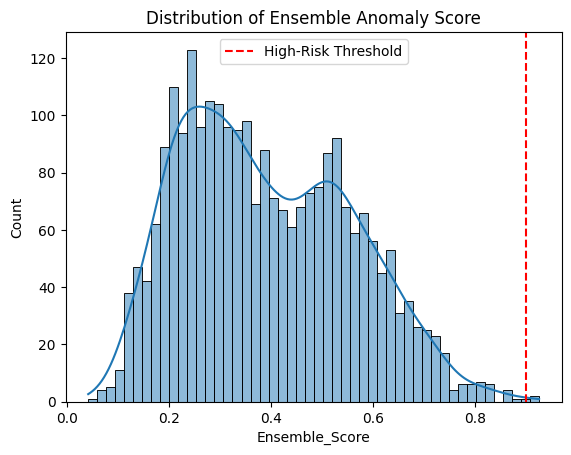

In [200]:
sns.histplot(df['Ensemble_Score'], bins=50, kde=True)
plt.axvline(0.9, color='red', linestyle='--', label='High-Risk Threshold')
plt.title('Distribution of Ensemble Anomaly Score')
plt.xlabel('Ensemble_Score')
plt.ylabel('Count')
plt.legend()
plt.show()


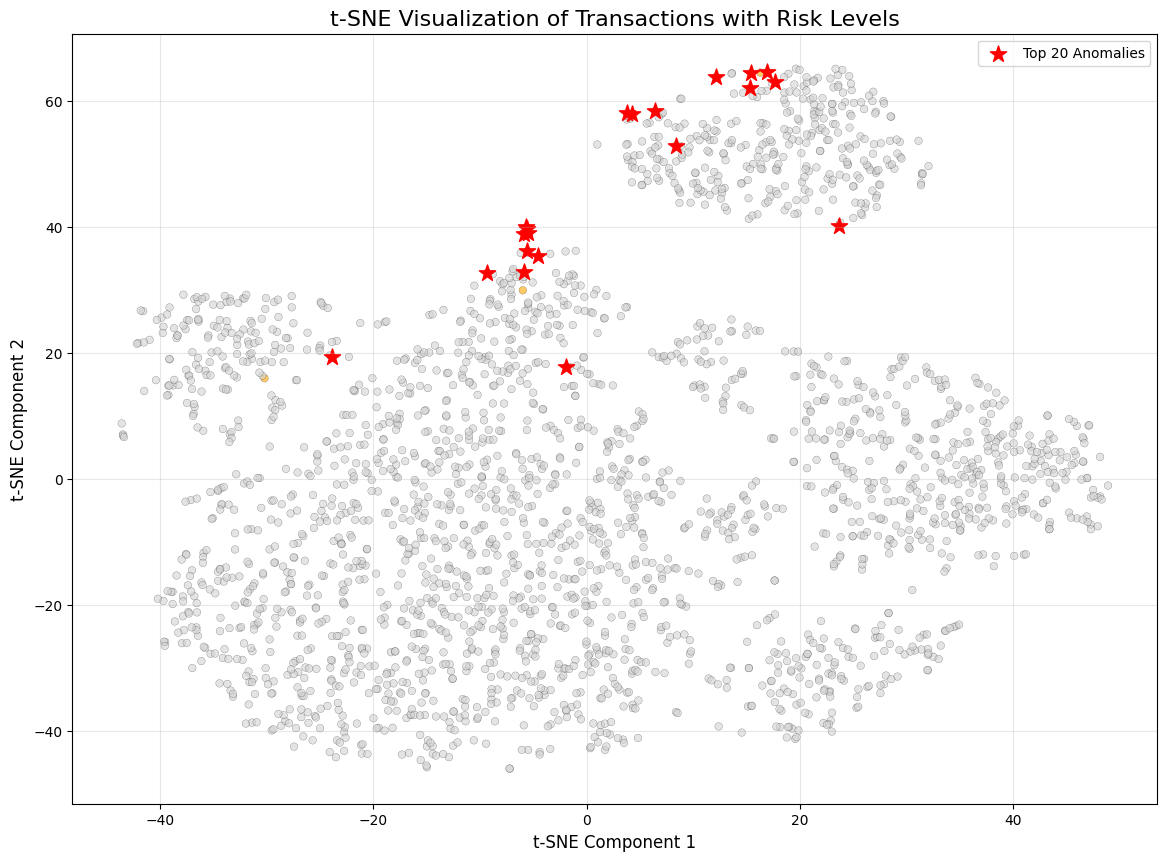

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Define risk tiers if not already defined ---
df['Risk_Level'] = pd.cut(
    df['Ensemble_Score'],
    bins=[0, 0.8, 0.9, 1],
    labels=['Low', 'Medium', 'High']
)

# --- Step 2: Select top anomalies (optional top 20 for stars) ---
top_anomalies = df.sort_values('Ensemble_Score', ascending=False).head(20)
top_indices = top_anomalies.index

# --- Step 3: Assign colors based on risk tier ---
color_map = {'Low':'lightgray', 'Medium':'orange', 'High':'red'}
colors = df['Risk_Level'].map(color_map)

# --- Step 4: Plot t-SNE ---
plt.figure(figsize=(14, 10))

# All points, colored by risk tier
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=colors, s=30, alpha=0.6, edgecolor='k', linewidth=0.2)

# Highlight top anomalies with stars
plt.scatter(tsne_results[top_indices, 0], tsne_results[top_indices, 1],
            s=150, c='red', marker='*', label='Top 20 Anomalies')

plt.title('t-SNE Visualization of Transactions with Risk Levels', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Confusion Matrix:
 [[469   9]
 [ 11  14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       478
           1       0.61      0.56      0.58        25

    accuracy                           0.96       503
   macro avg       0.79      0.77      0.78       503
weighted avg       0.96      0.96      0.96       503



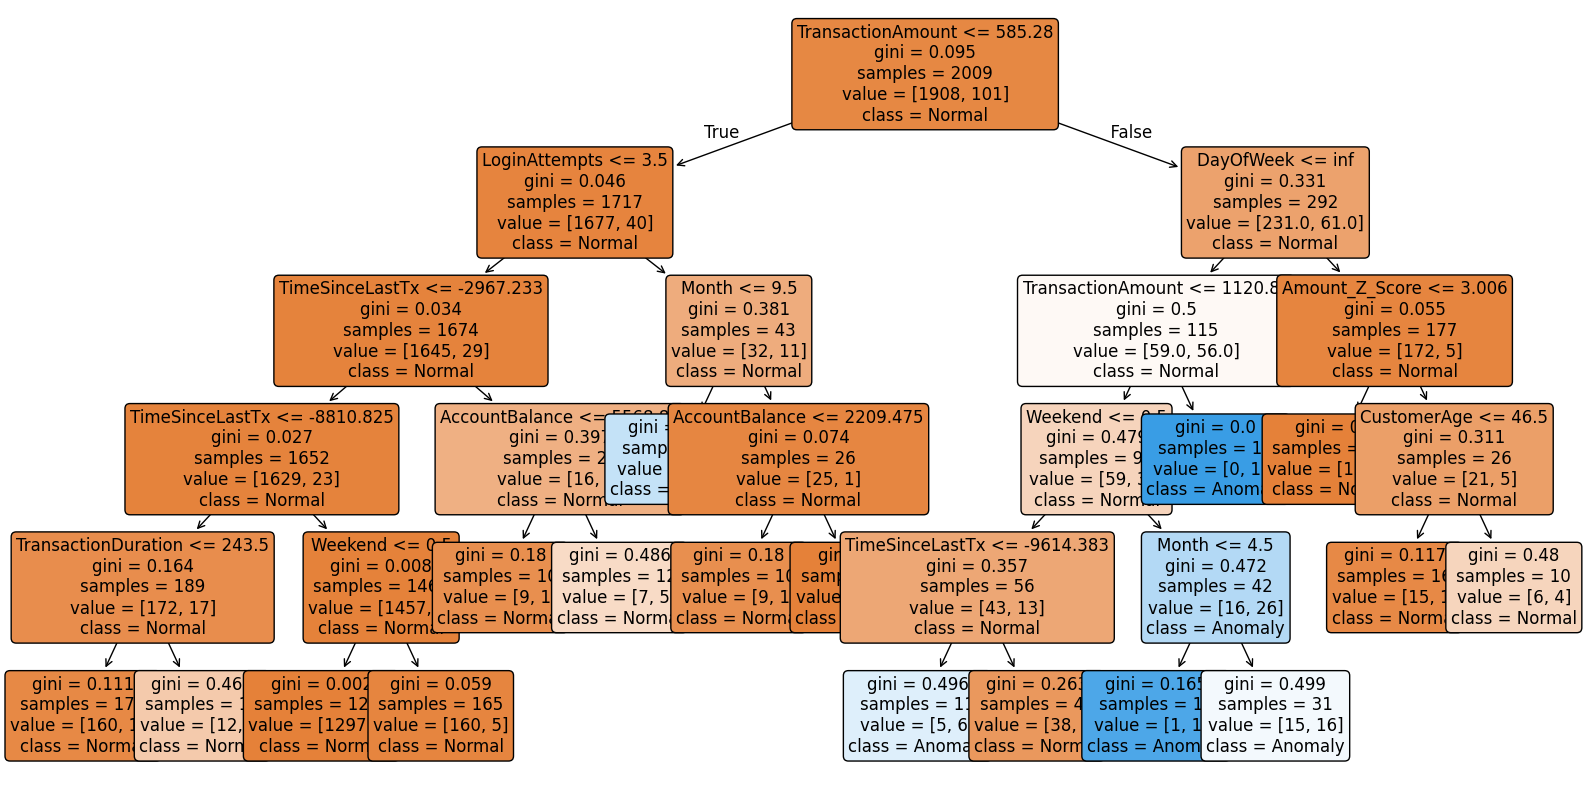

|--- TransactionAmount <= 585.28
|   |--- LoginAttempts <= 3.50
|   |   |--- TimeSinceLastTx <= -2967.23
|   |   |   |--- TimeSinceLastTx <= -8810.83
|   |   |   |   |--- TransactionDuration <= 243.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TransactionDuration >  243.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- TimeSinceLastTx >  -8810.83
|   |   |   |   |--- Weekend <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Weekend >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- TimeSinceLastTx >  -2967.23
|   |   |   |--- AccountBalance <= 5568.87
|   |   |   |   |--- class: 0
|   |   |   |--- AccountBalance >  5568.87
|   |   |   |   |--- class: 0
|   |--- LoginAttempts >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- class: 1
|   |   |--- Month >  9.50
|   |   |   |--- AccountBalance <= 2209.48
|   |   |   |   |--- class: 0
|   |   |   |--- AccountBalance >  2209.48
|   |   |   |   |--- class: 0
|--- TransactionAmount >  585.28
|   |--- DayOfWe

In [202]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


# 1️. Features and labels

feature_cols = [
    'TransactionAmount', 'AccountBalance', 'LoginAttempts', 
    'CustomerAge', 'TransactionDuration', 'DeviceTxCount', 
    'Amount_Z_Score', 'TimeSinceLastTx', 'Amount_to_AvgByType_Ratio',
    'Hour', 'DayOfWeek', 'Weekend', 'Month'
]

X = df[feature_cols]
y = df['Final_Anomaly']  # or 'Ensemble_Anomaly'

# 2️. Split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️. Train Decision Tree

dtree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)
dtree.fit(X_train, y_train)

# 4️. Evaluate

y_pred = dtree.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# 5️. Visualize Tree

plt.figure(figsize=(20,10))
plot_tree(
    dtree,
    feature_names=feature_cols,
    class_names=['Normal', 'Anomaly'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.show()

# 6️. Optional: Export textual rules
tree_rules = export_text(dtree, feature_names=feature_cols)
print(tree_rules)


The results demonstrate that the proposed ensemble model effectively distinguishes normal transactions from suspicious ones based on anomaly scores, confirming its separation capability.

**Conclusion:**

This project focuses on detecting anomalies in transaction data using data mining techniques. After preprocessing and feature engineering, multiple anomaly detection models were applied and combined using an ensemble approach to improve accuracy. The results show that ensemble-based anomaly detection is effective in identifying suspicious transactions and can be useful for real-world fraud detection systems.